In [1]:
# Tests for base Fault functionality: initialization, dumping, visualizations, etc.
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import numpy as np

warnings.filterwarnings('ignore')

sys.path.insert(0, '../../../seismiqb')

from batchflow import C, Pipeline
from seismiqb import Field, Fault, SeismicDataset, SeismicSampler, plot

In [39]:
""" You can manage cube and fault for the test:

CUBE_PATH : str
    Path to an existed seismic cube.
FAULT_PATH : str
    Path to an existed seismic fault.
"""
# Tests parameters
OUTPUT_DIR = './fault_test_files'

CUBE_PATH = os.path.join(OUTPUT_DIR, 'test_cube.sgy')
FAULT_PATH = os.path.join(OUTPUT_DIR, 'test_fault')

# Visualization parameters
SHOW_FIGURES = True

np.random.seed(42)

# Initialization

In [40]:
%%time

# ilines sticks
field = Field(CUBE_PATH)

sticks1 = np.array([
    [[100, 100, 25],
     [100, 130, 175]],
    [[120, 100, 25],
     [120, 130, 175]],
    [[140, 100, 25],
     [140, 130, 175]]
])

sticks2 = sticks1 + 30

CPU times: user 61.2 ms, sys: 20.3 ms, total: 81.4 ms
Wall time: 80.6 ms


In [41]:
dataset = SeismicDataset({field: [{'sticks': sticks1}]}, labels_class=Fault)

ppl = (dataset.p
      .make_locations(batch_size=16, generator=C('sampler'))
      .load_cubes(dst='images')
      .create_masks(dst='masks', width=C('width', default=3), sparse=C('sparse', default=False))
)

  0%|                                                                                                         …

  0%|                                                                                                         …

# Check width

In [42]:
sampler = SeismicSampler(labels=dataset.labels, crop_shape=(1, 64, 64), mode='fault', threshold=0, extend=False)

for width in range(1, 10, 2):
    ppl.set_config({'width': width, 'sampler': sampler})
    batch = ppl.next_batch()
    assert (batch.masks.sum(axis=2) <= width+1).all(), f"mask is wider then {width}"

# Check 3D crops

In [43]:
dataset = SeismicDataset({field: [{'sticks': s} for s in [sticks1, sticks2]]}, labels_class=Fault)
sampler = SeismicSampler(labels=dataset.labels, crop_shape=(64, 64, 64), mode='fault', threshold=0)
width = 2

ppl.set_dataset(dataset)
ppl.set_config({'sampler': sampler, 'width': width})
batch = ppl.next_batch()

  0%|                                                                                                         …

  0%|                                                                                                         …

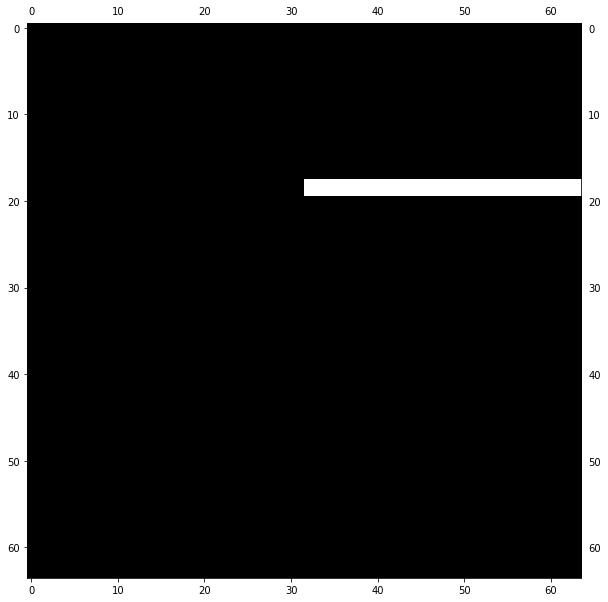

In [44]:
plot(batch.masks[0, ..., 20], show=SHOW_FIGURES)

In [49]:
ppl.set_config({'sampler': sampler, 'width': width, 'sparse': True})
batch = ppl.next_batch()

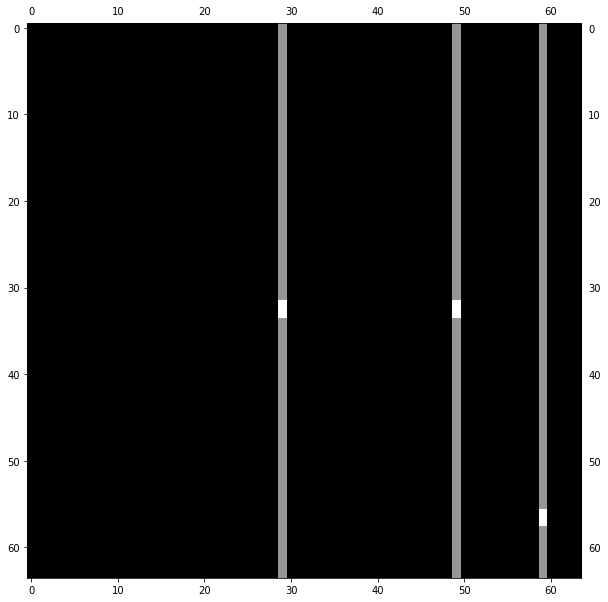

In [50]:
plot(batch.masks[0, ..., 20], show=SHOW_FIGURES)

In [51]:
for i in range(len(batch)):
    loc = np.where(batch.masks[i][:, 0, 0] != -1)[0] + batch.locations[i][0].start
    assert np.isin(loc, np.concatenate([sticks1[:, 0, 0], sticks2[:, 0, 0]])).all(), "There are unlabeled slides with points"